# Leveraging LangChain to Build a Multi-Document Querying Application

We'll be building off the following diagram off the following diagram!

While it may look a bit complicated, we'll be tackling each piece individually!

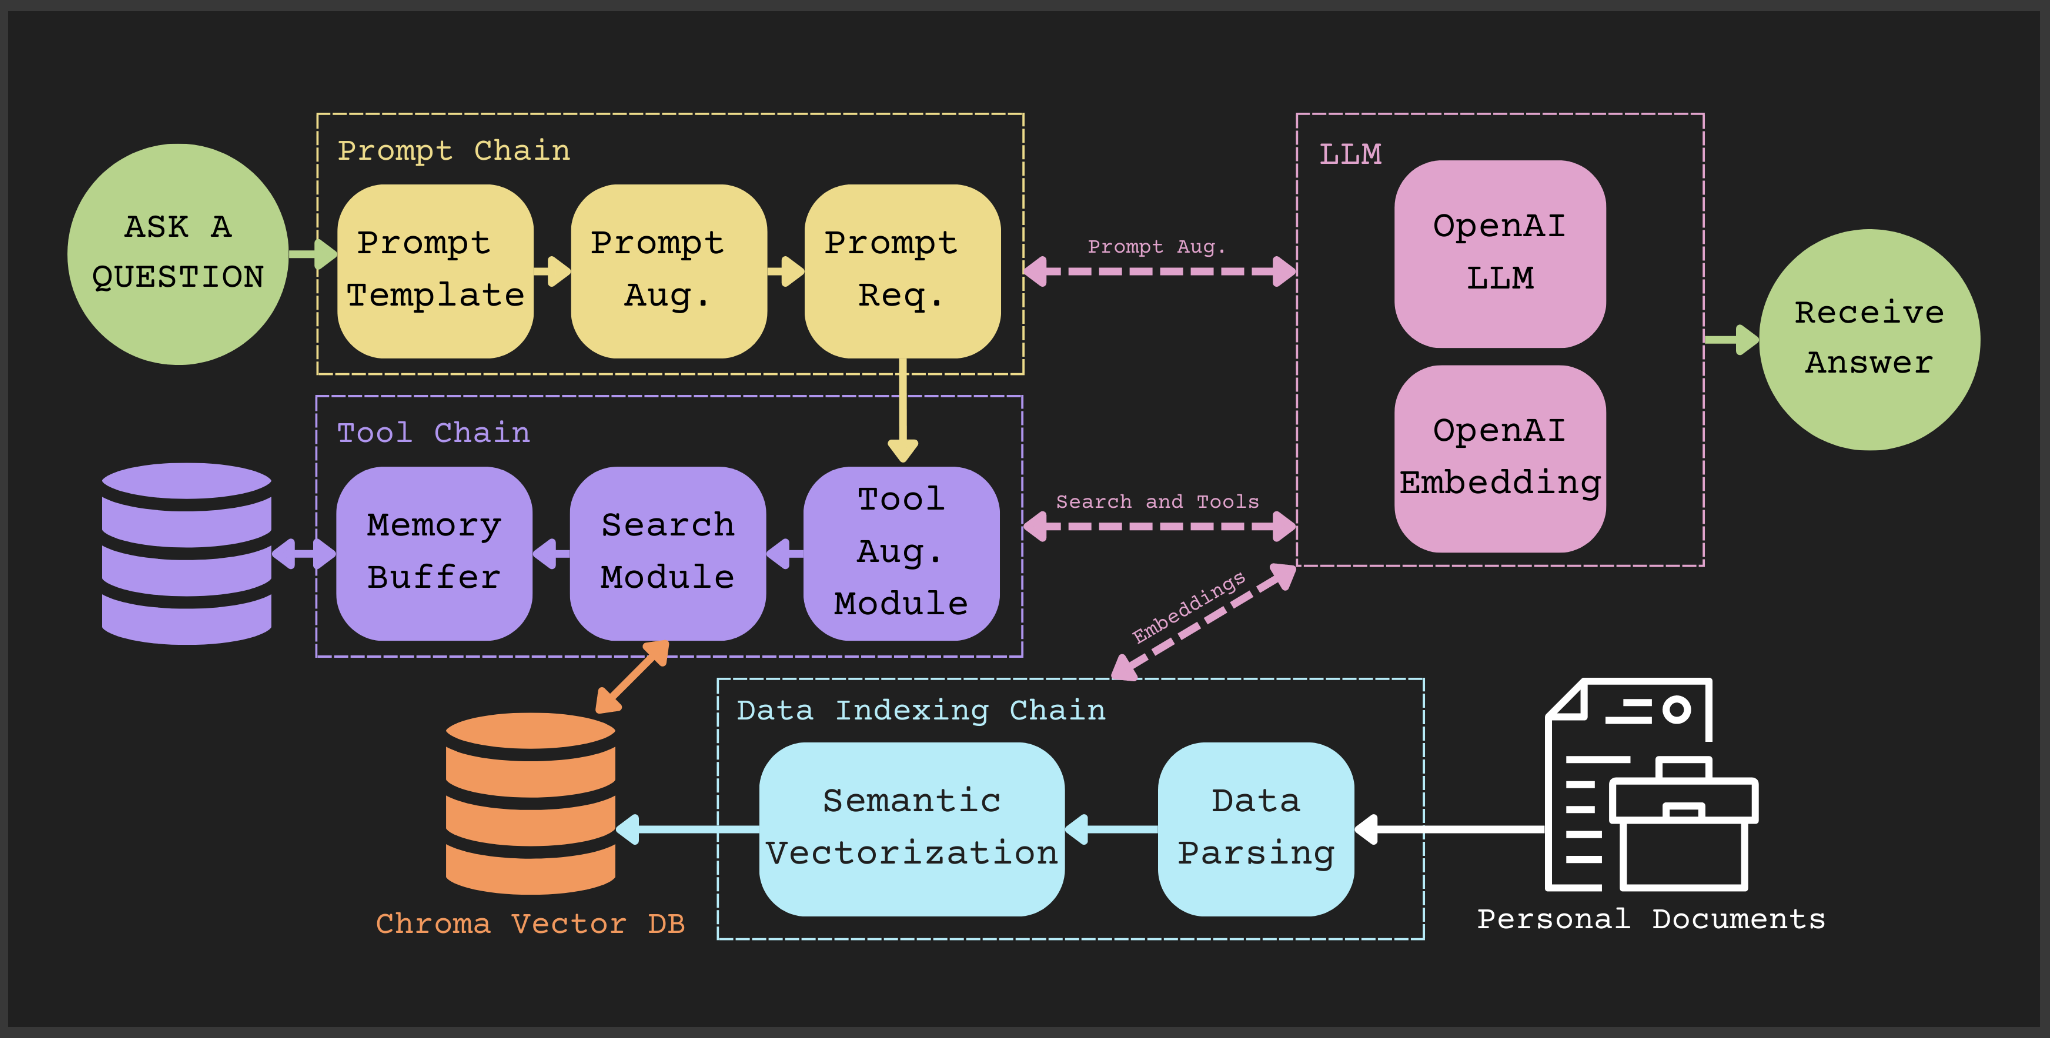

In [1]:
!pip install langchain openai langchain-openai chromadb tiktoken unstructured -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.0/237.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Loading Source Data

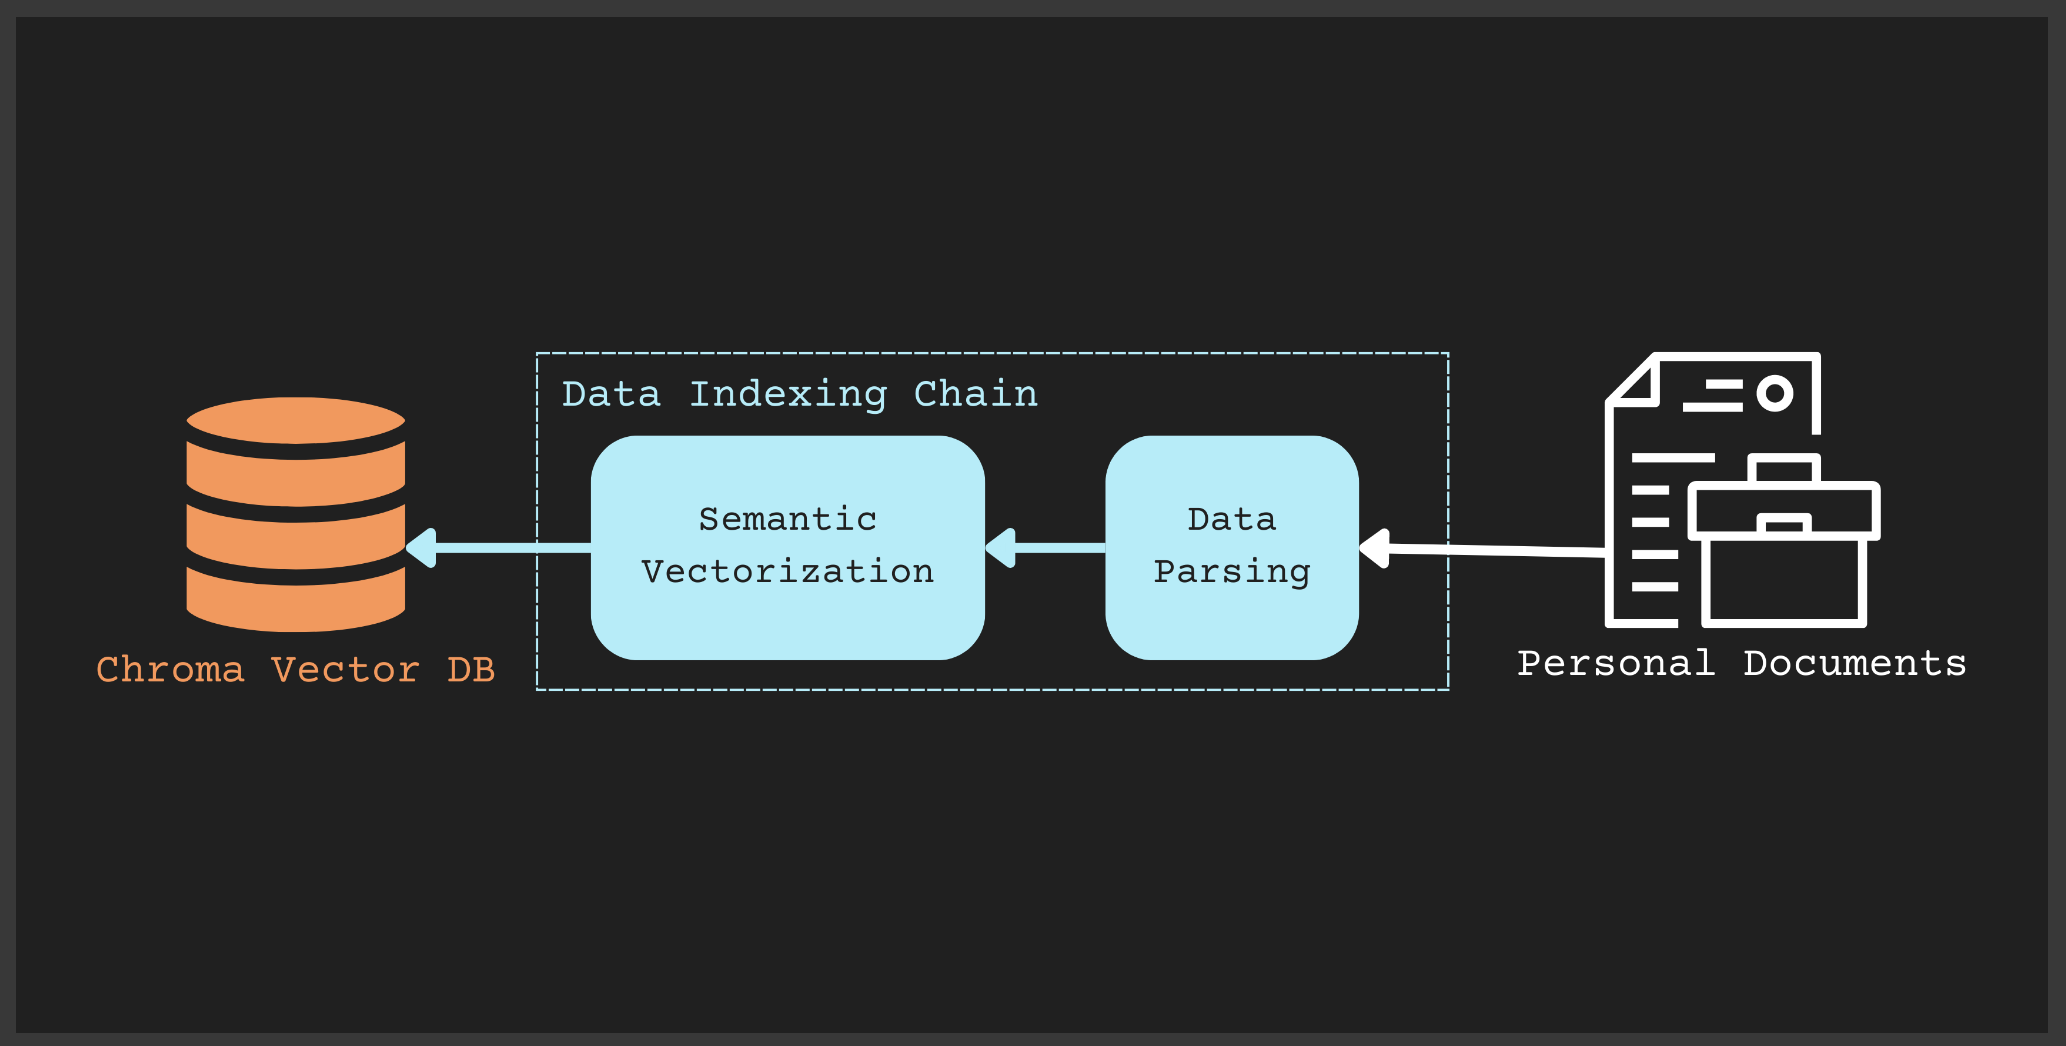


In order to get started, we'll first need a number of documents that we want to collect and manage.

To start us off, we'll be loading in the Alice in Wonderland series as well as some additional supplemental documents.

Let's get downloading!

In [2]:
!wget https://gist.githubusercontent.com/phillipj/4944029/raw/75ba2243dd5ec2875f629bf5d79f6c1e4b5a8b46/alice_in_wonderland.txt

--2024-02-02 05:24:24--  https://gist.githubusercontent.com/phillipj/4944029/raw/75ba2243dd5ec2875f629bf5d79f6c1e4b5a8b46/alice_in_wonderland.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148574 (145K) [text/plain]
Saving to: ‘alice_in_wonderland.txt’

alice_in_wonderland 100%[===================>] 145.09K  --.-KB/s    in 0.02s   

2024-02-02 05:24:24 (6.48 MB/s) - ‘alice_in_wonderland.txt’ saved [148574/148574]



In [3]:
!wget https://raw.githubusercontent.com/LearnWebCode/json-example/master/animals-1.json

--2024-02-02 05:24:25--  https://raw.githubusercontent.com/LearnWebCode/json-example/master/animals-1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420 [text/plain]
Saving to: ‘animals-1.json’

animals-1.json      100%[===================>]     420  --.-KB/s    in 0s      

2024-02-02 05:24:25 (9.67 MB/s) - ‘animals-1.json’ saved [420/420]



In [4]:
# Get all the content of the directory
from glob import glob

files = glob("*")


files

['alice_in_wonderland.txt', 'animals-1.json', 'sample_data']

In [5]:
import shutil
import os

Create a directory and load the downloaded file

In [6]:
os.mkdir('./data')

In [7]:
for ind_file in files:
  if ind_file.find(".") == -1:
    continue

  file_extension = ind_file.split(".")[-1]

  if not os.path.exists("./data/" + file_extension):
    os.mkdir("./data/" + file_extension)

  shutil.move(ind_file, "./data/" + file_extension)

In [8]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Load the document

In [9]:
from langchain_community.document_loaders import DirectoryLoader

loader = DirectoryLoader("/content/data/txt")

docs = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Break the document into chunks

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(docs)

# Create Embeddings

In [11]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key = OPENAI_API_KEY)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


# Store in DB

In [12]:
from langchain_community.vectorstores import Chroma

In [13]:
# save to disk
persist_directory = 'vector_db'
db2 = Chroma.from_documents(documents, embeddings, persist_directory=persist_directory)

In [14]:
db2.similarity_search("rabbit")

[Document(page_content="The long grass rustled at her feet as the White Rabbit hurried by--the frightened Mouse splashed his way through the neighbouring pool--she could hear the rattle of the teacups as the March Hare and his friends shared their never-ending meal, and the shrill voice of the Queen ordering off her unfortunate guests to execution--once more the pig-baby was sneezing on the Duchess's knee, while plates and dishes crashed around it--once more the shriek of the Gryphon, the squeaking of the Lizard's slate-pencil, and the choking of the suppressed guinea-pigs, filled the air, mixed up with the distant sobs of the miserable Mock Turtle.", metadata={'source': '/content/data/txt/alice_in_wonderland.txt'}),
 Document(page_content="It was the White Rabbit, trotting slowly back again, and looking anxiously about as it went, as if it had lost something; and she heard it muttering to itself `The Duchess! The Duchess! Oh my dear paws! Oh my fur and whiskers! She'll get me executed

In [15]:
# load from disk
db3 = Chroma(persist_directory="vector_db", embedding_function=embeddings)
docs = db3.similarity_search('rabbit')
print(docs[0].page_content)

The long grass rustled at her feet as the White Rabbit hurried by--the frightened Mouse splashed his way through the neighbouring pool--she could hear the rattle of the teacups as the March Hare and his friends shared their never-ending meal, and the shrill voice of the Queen ordering off her unfortunate guests to execution--once more the pig-baby was sneezing on the Duchess's knee, while plates and dishes crashed around it--once more the shriek of the Gryphon, the squeaking of the Lizard's slate-pencil, and the choking of the suppressed guinea-pigs, filled the air, mixed up with the distant sobs of the miserable Mock Turtle.


## Adding additional resources - .json file!

In [16]:
json_loader = DirectoryLoader("/content/data/json")

json_docs = loader.load()

json_documents = text_splitter.split_documents(json_docs)

db2 = Chroma.from_documents(documents, embeddings, persist_directory=persist_directory)

In [20]:
db2.similarity_search("cookies")

[Document(page_content="By this time she had found her way into a tidy little room with a table in the window, and on it (as she had hoped) a fan and two or three pairs of tiny white kid gloves:  she took up the fan and a pair of the gloves, and was just going to leave the room, when her eye fell upon a little bottle that stood near the looking- glass. There was no label this time with the words `DRINK ME,' but nevertheless she uncorked it and put it to her lips. `I know SOMETHING interesting is sure to happen,' she said to herself, `whenever I eat or drink anything; so I'll just see what this bottle does. I do hope it'll make me grow large again, for really I'm quite tired of being such a tiny little thing!'", metadata={'source': '/content/data/txt/alice_in_wonderland.txt'}),
 Document(page_content="By this time she had found her way into a tidy little room with a table in the window, and on it (as she had hoped) a fan and two or three pairs of tiny white kid gloves:  she took up the 

# Tool Chain

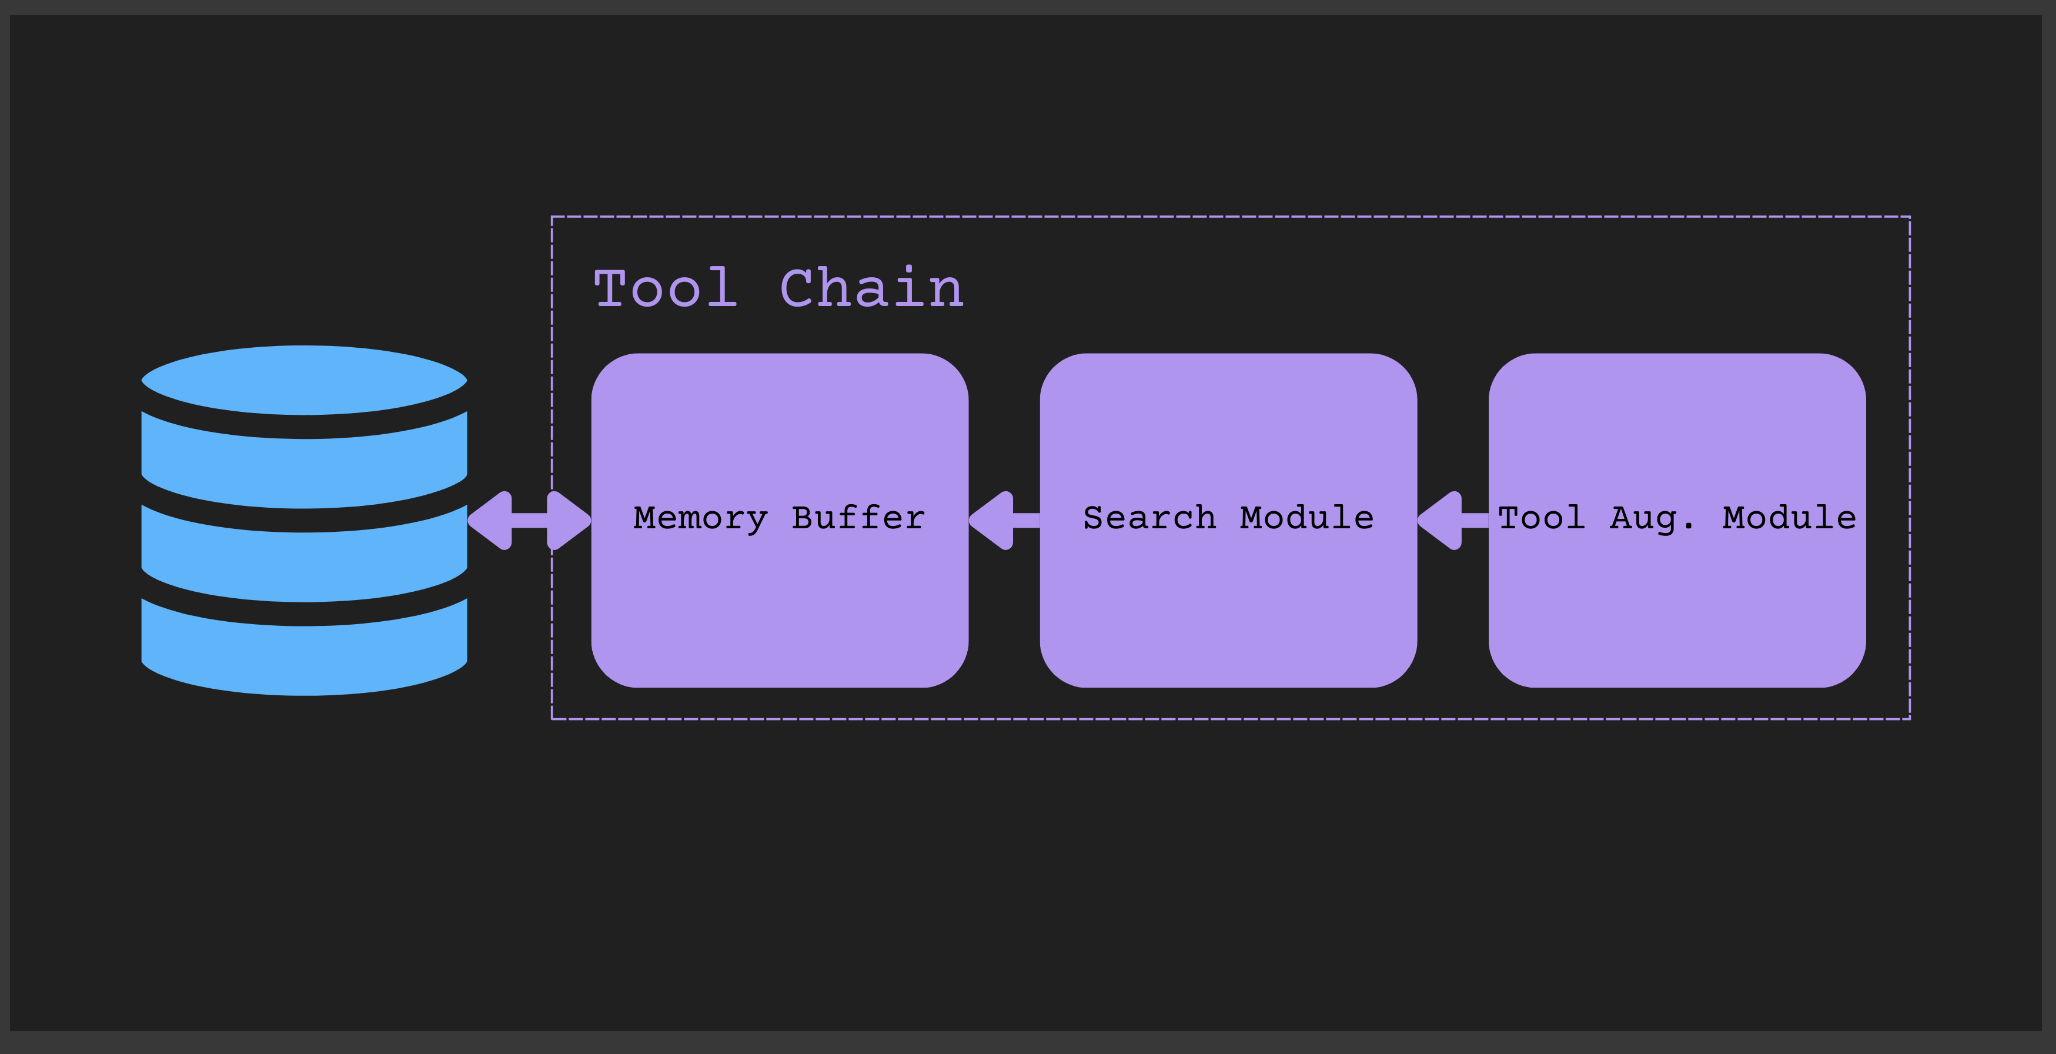

In [21]:
# Load model
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model = "gpt-3.5-turbo", openai_api_key = OPENAI_API_KEY)

In [22]:
retriever = db2.as_retriever()

In [23]:
from langchain.chains import RetrievalQA

alice_qa = RetrievalQA.from_chain_type(llm=llm,
                                       chain_type="stuff",
                                       retriever=retriever,
                                       verbose = True)

In [24]:
alice_qa.run("What is up with the Cheshire Cat?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...

> Finished chain.


'The Cheshire Cat is known for its ability to grin. According to the Duchess, all Cheshire cats can grin, and most cats can as well. The Cat itself only grins when it sees Alice. It appears to be good-natured, but Alice also notices its long claws and many teeth, so she treats it with respect. When Alice asks the Cat which way she should go, the Cat responds by saying that it depends on where she wants to get to. It also tells her that as long as she walks long enough, she is sure to get somewhere.'

# Using Agent

In [25]:
!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [26]:
from google.colab import userdata
SERPAPI = userdata.get('SERPAPI')

In [28]:
from langchain.utilities import SerpAPIWrapper

search = SerpAPIWrapper(serpapi_api_key = SERPAPI)

In [30]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.llms import OpenAI

In [31]:
tools = [
    Tool(
        name = "Alice in Wonderland QA System",
        func=alice_qa.run,
        description="useful for when you need to answer questions about Alice in Wonderland. Input should be a fully formed question."
    ),
    Tool(
        name = "Backup Alice Google Search",
        func=search.run,
        description="useful for when you need to answer questions about Alice in Wonderland but only when the Alice in Wonderland QA System couldn't answer the query. Input should be a fully formed question."
    ),
]

In [32]:
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=True)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [33]:
agent.run("What is the deal with the Cheshire Cat?")



> Entering new AgentExecutor chain...
I'm not sure about the specifics of the Cheshire Cat, but it sounds like a character from Alice in Wonderland.
Action: Alice in Wonderland QA System
Action Input: "What is the deal with the Cheshire Cat?"

> Entering new RetrievalQA chain...

> Finished chain.

Observation: The Cheshire Cat is a character in Alice's Adventures in Wonderland. It is known for its ability to grin and disappear, leaving only its smile behind. The Duchess mentions that Cheshire cats always grin and Alice expresses her surprise at this. The Cat later appears and engages in a conversation with Alice, offering cryptic advice and answers to her questions.
Thought:The Alice in Wonderland QA System provided a detailed answer about the Cheshire Cat's characteristics and role in the story.
Final Answer: The Cheshire Cat is a character in Alice's Adventures in Wonderland known for its ability to grin and disappear, leaving only its smile behind. It offers cryptic advice and an

"The Cheshire Cat is a character in Alice's Adventures in Wonderland known for its ability to grin and disappear, leaving only its smile behind. It offers cryptic advice and answers to Alice's questions."

# Memory in Agent

In [35]:
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory

memory = ConversationBufferMemory(memory_key="history")

readonlymemory = ReadOnlySharedMemory(memory=memory) # memory cannot be edited by model

In order to let our Tools leverage the memory - we'll want to add the ability to read the memory to their chains!

In [36]:
alice_qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    memory=readonlymemory)

Now we can re-create our Tools list - this time using the memory capable version of the alice_qa chain!

In [37]:
tools = [
    Tool(
        name = "Alice in Wonderland QA System",
        func=alice_qa.run,
        description="useful for when you need to answer questions about Alice in Wonderland. Input should be a fully formed question."
    ),
    Tool(
        name = "Backup Alice Google Search",
        func=search.run,
        description="useful for when you need to answer questions about Alice in Wonderland but only when the Alice in Wonderland QA System couldn't answer the query. Input should be a fully formed question."
    ),
]

https://python.langchain.com/docs/modules/memory/agent_with_memory

In [38]:
from langchain.agents import AgentExecutor, Tool, ZeroShotAgent
from langchain.chains import LLMChain


prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"

{history}
Question: {input}
{agent_scratchpad}"""

prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["input", "history", "agent_scratchpad"],
)


Add prompt to LLMChain

In [39]:
llm_chain = LLMChain(llm=llm,
                     prompt=prompt)

Set up agent prompt

In [40]:
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)

agent_chain = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True, memory=memory
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain.agents.mrkl.base.ZeroShotAgent` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use create_react_agent instead.
  warn_deprecated(


In [41]:
agent_chain.run(input="What is the deal with the Cheshire Cat?")



> Entering new AgentExecutor chain...
Thought: I'm not sure about the details of the Cheshire Cat in Alice in Wonderland.
Action: Alice in Wonderland QA System
Action Input: What is the deal with the Cheshire Cat?
Observation: The Cheshire Cat is a character in Alice's Adventures in Wonderland. It is known for its ability to grin and disappear, leaving only its smile behind. The Duchess mentions that Cheshire cats always grin and Alice expresses her surprise at this. The Cat later appears and engages in a conversation with Alice, offering cryptic advice and answers to her questions.
Thought:I now know the final answer
Final Answer: The Cheshire Cat is a character in Alice's Adventures in Wonderland known for its ability to grin and disappear, leaving only its smile behind. It offers cryptic advice and answers to Alice's questions.

> Finished chain.


"The Cheshire Cat is a character in Alice's Adventures in Wonderland known for its ability to grin and disappear, leaving only its smile behind. It offers cryptic advice and answers to Alice's questions."

In [42]:
agent_chain.run(input="What makes it enigmatic?")



> Entering new AgentExecutor chain...
Thought: I'm not sure about the specific details of why the Cheshire Cat is enigmatic.
Action: Alice in Wonderland QA System
Action Input: What makes the Cheshire Cat enigmatic?
Observation: The Cheshire Cat is enigmatic because it has the ability to disappear and reappear at will, leaving only its grin behind. It also speaks in riddles and gives vague answers to Alice's questions, adding to its mysterious nature.
Thought:I now know the final answer
Final Answer: The Cheshire Cat is enigmatic because of its ability to disappear, its cryptic advice, and its vague answers to Alice's questions.

> Finished chain.


"The Cheshire Cat is enigmatic because of its ability to disappear, its cryptic advice, and its vague answers to Alice's questions."

In [43]:
agent_chain.run(input="What are some of its riddles?")



> Entering new AgentExecutor chain...
Thought: I should use the Alice in Wonderland QA System to find out some of the Cheshire Cat's riddles.
Action: Alice in Wonderland QA System
Action Input: What are some of the Cheshire Cat's riddles?
Observation: There is no mention of the Cheshire Cat's riddles in the given context.
Thought:The Alice in Wonderland QA System couldn't answer the query, so I should use the Backup Alice Google Search to find out some of the Cheshire Cat's riddles.
Action: Backup Alice Google Search
Action Input: Cheshire Cat riddles
Observation: ['Tongue twister: The Red Queen raged, The Red Queen Roared! Off with their heads! The Red Queen raged, The Red Queen Roared!', 'Fallen down the rabbit hole... ... Amy H. Quotes.', "Alice asked the Cheshire Cat, who was sitting in a tree, “What road do I take?” The cat asked, “Where do you want to go?” “I don't know,” Alice answered.", 'In Riddles of Wonderland, Cheshire Cat is healing instead of doing damage during his spe

'Some of the Cheshire Cat\'s riddles include: "Tongue twister: The Red Queen raged, The Red Queen Roared! Off with their heads! The Red Queen raged, The Red Queen Roared!", "Alice asked the Cheshire Cat, who was sitting in a tree, \'What road do I take?\' The cat asked, \'Where do you want to go?\' \'I don\'t know,\' Alice answered.", "With a grin, I\'ll bid you farewell, And with madness, enchant you all. What am I? Answer: The Cheshire Cat."'

In [44]:
agent_chain.run(input="What is Alice's response to that riddle?")



> Entering new AgentExecutor chain...
Thought: I'm not sure what Alice's response to that specific riddle is.
Action: Alice in Wonderland QA System
Action Input: What is Alice's response to the Cheshire Cat's riddle "With a grin, I'll bid you farewell, And with madness, enchant you all. What am I?"
Observation: There is no mention of Alice responding to the Cheshire Cat's riddle in the given context.
Thought:I couldn't find any information about Alice's response to that specific riddle.
Action: Backup Alice Google Search
Action Input: Alice's response to the Cheshire Cat's riddle "With a grin, I'll bid you farewell, And with madness, enchant you all. What am I?"
Observation: ["With a grin, I'll bid you farewell,. And with madness, enchant you all. What am I? Answer: The Cheshire Cat. Riddle: Within a mad tea party's ...", "I beam, I shine, I sparkle white. I'll brighten the day with a single light. I'll charm and enchant all. I'll bring the best in you all. What am I?", 'There are ac

'I couldn\'t find any specific information about Alice\'s response to the Cheshire Cat\'s riddle "With a grin, I\'ll bid you farewell, And with madness, enchant you all."'